# **(PCA) of multidimensional points **


In this Jupyter notebook, we will be performing Principal Component Analysis (PCA) using the points provided is exp_2d_blobs using the easy approach.

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.datasets import make_blobs
import pylab as pl
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
# from robotikos.metric import IdentityFeature
# from robotikos.metric import (NormalizedSumSquaredDiffMetric,
#                               NormalizedSumAbsDiffMetric)
from thetan.theta import theta_g1, assign
from thetan.theta import distance_matrix as tdm
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [2]:
thetanTimes = []
kmeans_plus_plus_Times = []
xDimensions = ['2d', '3d', '4d']

### Accuracy with 2d data 

In [3]:
    evaluation_thr = 0.1
    verbose = True
    show_thr = False
    radius = 4
    n_local_samples = 30
    blob_dis = 33
    cluster_per_dim = 10
    scores = {}
    timings = {}
    blob_dis = 10
    cluster_x = 10
    cluster_y = 10
    
    xx = np.arange(-1*blob_dis*cluster_x//2, blob_dis*cluster_x//2, blob_dis)
    yy = np.arange(-1*blob_dis*cluster_y//2, blob_dis*cluster_y//2, blob_dis)

    xx, yy = np.meshgrid(xx, yy)
    n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                        np.ravel(yy)[:, np.newaxis]))



    gt_centroids = []
    X = np.zeros((n_local_samples * n_centres.shape[0], 2))
    y = np.zeros((n_local_samples * n_centres.shape[0]), dtype=np.int16)
    for i in range(n_centres.shape[0]):
        cpos = n_centres[i]

        local_X = cpos + np.random.normal(0, 1, (n_local_samples, 2))
        X[i * n_local_samples: (i + 1) * n_local_samples] = local_X
        y[i * n_local_samples: (i + 1) * n_local_samples] = i
        gt_centroids.append(local_X.mean(axis=0))

    gt_centroids = np.array(gt_centroids)

    points = X
    labels = y
    sz = len(n_centres)

    centroids = gt_centroids
    
    print('Before shuffling')
    print(points[:10])

    points_idx = np.arange(np.shape(points)[0])
    np.random.shuffle(points_idx)
    new_points = np.zeros(np.shape(points))
    new_labels = np.zeros(np.shape(labels))
    for i, idx in zip(range(np.shape(points)[0]), points_idx):
        new_points[i] = points[idx]
        new_labels[i] = labels[idx]

    points = new_points
    labels2d = new_labels
    points2d = points.copy();
    print('After shuffling')
    print(points[:10])

    print('Number of points ', points.shape)

    print('Number of gold centroids ', np.prod(sz))

    # kmeans ++ 
    t1 = time()
    kmeans = KMeans(n_clusters=np.prod(sz), init='k-means++', n_init=1,
                    max_iter=300, tol=0.0001, random_state=0).fit(points)
    t2 = time()

    kmeans_time = t2 - t1
    print('kmeans++ ', kmeans_time)

    kcentroids2d = kmeans.cluster_centers_
    klabels2d = kmeans.labels_
    
    
    # if verbose:
    #     plot_centroids_clusters(points, kcentroids, klabels,
    #                             'kmeans++', exp_type,
    #                             initial_centroids=centroids)

    # scores['kmeans++'] = {}
    # for mode in modes:
    #     if mode == 'SIL':
    #         scores['kmeans++'][mode] = evaluate_centroids(thr=evaluation_thr, mode=mode, X=points, label=klabels)
    #     elif mode == 'NMI' or mode == 'FMS' or mode == 'RAI':
    #         scores['kmeans++'][mode] = evaluate_centroids(thr=evaluation_thr, mode=mode, label=klabels, true_label=labels)
    #     elif mode == 'SSD':
    #         scores['kmeans++'][mode] = evaluate_centroids(kcentroids, centroids, evaluation_thr, mode=mode)
    # timings['kmeans++'] = kmeans_time

    tmp = 0
    
    #thetan
    theta = 6.0

    t1 = time()
    tcentroids2d, tlabels2d = theta_g1(points, theta=theta,)

    t2 = time()

    tm_time = t2 - t1
    thetanTimes.append(tm_time)
    kmeans_plus_plus_Times.append(kmeans_time)

    print('tm ', tm_time)
    print('Speedup', kmeans_time/tm_time)




Before shuffling
[[-49.82423841 -49.57698988]
 [-49.32053355 -49.3774753 ]
 [-51.04363277 -50.47659885]
 [-50.49381867 -49.52490695]
 [-51.02254585 -50.25488824]
 [-49.75144654 -49.01478515]
 [-49.78166457 -49.49040432]
 [-49.27668696 -48.90425981]
 [-49.40038053 -48.99073031]
 [-50.83539395 -50.79084724]]
After shuffling
[[ 39.94199216  29.02387999]
 [ -8.93618683   9.75261883]
 [-30.24885492  18.70665605]
 [ 29.61377741  22.04219617]
 [-30.44052924 -50.34020456]
 [ -1.00029078  31.22880559]
 [-40.19961186   1.00984905]
 [-51.72140653 -10.78097388]
 [-39.49410708  18.21124207]
 [ 21.10892579  18.16459091]]
Number of points  (3000, 2)
Number of gold centroids  100
kmeans++  0.046630859375
tm  0.0026121139526367188
Speedup 17.851770719240598


### Load 3d data from exp_2d_blobs test.py

In [4]:
verbose = True
show_thr = False
evaluation_thr = 0.1
radius = 4
n_local_samples = 30
blob_dis = 33
cluster_per_dim = 10
blob_dis = 15
cluster_x = 10
cluster_y = 10
cluster_z = 10
numberOfDimensions = 3
#measurement for centroid accuracy
#should be one 1000 clusters in 3dimensions 
xx = np.arange(-1*blob_dis*cluster_x//2, blob_dis*cluster_x//2, blob_dis)
yy = np.arange(-1*blob_dis*cluster_y//2, blob_dis*cluster_y//2, blob_dis)
zz = np.arange(-1*blob_dis*cluster_z//2, blob_dis*cluster_z//2, blob_dis)

xx, yy, zz = np.meshgrid(xx, yy, zz )
#of centers should be 1000
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                    np.ravel(yy)[:, np.newaxis], 
                    np.ravel(zz)[:,np.newaxis]))



gt_centroids = []
#here the number of dimensions is increased to 3 
# X = np.zeros((n_local_samples * n_centres.shape[0], 3))
X = np.zeros((n_local_samples * n_centres.shape[0], numberOfDimensions))
y = np.zeros((n_local_samples * n_centres.shape[0]), dtype=np.int16)
for i in range(n_centres.shape[0]):
    cpos = n_centres[i]

    local_X = cpos + np.random.normal(0, 1, (n_local_samples, numberOfDimensions))
    X[i * n_local_samples: (i + 1) * n_local_samples] = local_X
    y[i * n_local_samples: (i + 1) * n_local_samples] = i
    gt_centroids.append(local_X.mean(axis=0))

gt_centroids = np.array(gt_centroids)

points = X
points3d = points.copy();

labels = y
sz = len(n_centres)

centroids = gt_centroids
#put everything one line 
#goal for next week 
#plot X and y and attempt to plot up to 5 6 dimensions 
#create a function to return experiment set up 




print('Before shuffling')
print(points[:10])

points_idx = np.arange(np.shape(points)[0])
np.random.shuffle(points_idx)
new_points = np.zeros(np.shape(points))
new_labels = np.zeros(np.shape(labels))
for i, idx in zip(range(np.shape(points)[0]), points_idx):
    new_points[i] = points[idx]
    new_labels[i] = labels[idx]

points3d = new_points
labels3d = new_labels

print('After shuffling')
print(points[:10])
dfPoints = pd.DataFrame(points, columns = ['X','Y','Z'])


t1 = time()
kmeans = KMeans(n_clusters=np.prod(sz), init='k-means++', n_init=1,
                max_iter=300, tol=0.0001, random_state=0).fit(points)
t2 = time()

kmeans_time = t2 - t1
print('kmeans++ ', kmeans_time)

kcentroids3d = kmeans.cluster_centers_
klabels3d = kmeans.labels_
tmp = 0


#calculating theta centroids
theta = 6.0

t1 = time()
tcentroids3d, tlabels3d = theta_g1(points, theta=theta,)
t2 = time()

tm_time = t2 - t1
print('tm ', tm_time)

thetanTimes.append(tm_time);
kmeans_plus_plus_Times.append(kmeans_time)



Before shuffling
[[-75.63324748 -74.11857421 -73.81954071]
 [-76.46045383 -74.80641786 -75.87622839]
 [-74.73635757 -74.49598303 -74.71030783]
 [-76.74272324 -76.60409178 -74.08186727]
 [-75.18465871 -73.99519688 -75.15498117]
 [-75.67005946 -74.71774758 -76.86473697]
 [-74.91016133 -75.06769776 -73.9336271 ]
 [-74.63657632 -74.19328785 -74.33122137]
 [-75.01439576 -75.7922264  -76.01362796]
 [-74.27757322 -75.21628943 -75.53008243]]
After shuffling
[[-75.63324748 -74.11857421 -73.81954071]
 [-76.46045383 -74.80641786 -75.87622839]
 [-74.73635757 -74.49598303 -74.71030783]
 [-76.74272324 -76.60409178 -74.08186727]
 [-75.18465871 -73.99519688 -75.15498117]
 [-75.67005946 -74.71774758 -76.86473697]
 [-74.91016133 -75.06769776 -73.9336271 ]
 [-74.63657632 -74.19328785 -74.33122137]
 [-75.01439576 -75.7922264  -76.01362796]
 [-74.27757322 -75.21628943 -75.53008243]]
kmeans++  1.7964518070220947
tm  0.10676002502441406


### Load 4d data from exp_2d_blobs test.py

In [5]:
verbose = True
show_thr = False
evaluation_thr = 0.1
radius = 4
n_local_samples = 30
blob_dis = 33
cluster_per_dim = 10
blob_dis = 15
cluster_x = 10
cluster_y = 10
cluster_z = 10
cluster_u = 10
numberOfDimensions = 4
#measurement for centroid accuracy
#should be one 1000 clusters in 3dimensions 
xx = np.arange(-1*blob_dis*cluster_x//2, blob_dis*cluster_x//2, blob_dis)
yy = np.arange(-1*blob_dis*cluster_y//2, blob_dis*cluster_y//2, blob_dis)
zz = np.arange(-1*blob_dis*cluster_z//2, blob_dis*cluster_z//2, blob_dis)
uu = np.arange(-1*blob_dis*cluster_u//2, blob_dis*cluster_u//2, blob_dis)

xx, yy, zz, uu = np.meshgrid(xx, yy, zz, uu)
#of centers should be 1000
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                    np.ravel(yy)[:, np.newaxis], 
                    np.ravel(zz)[:,np.newaxis],
                    np.ravel(uu)[:,np.newaxis]))



gt_centroids = []
#here the number of dimensions is increased to 3 
# X = np.zeros((n_local_samples * n_centres.shape[0], 3))
X = np.zeros((n_local_samples * n_centres.shape[0], numberOfDimensions))
y = np.zeros((n_local_samples * n_centres.shape[0]), dtype=np.int16)
for i in range(n_centres.shape[0]):
    cpos = n_centres[i]

    local_X = cpos + np.random.normal(0, 1, (n_local_samples, numberOfDimensions))
    X[i * n_local_samples: (i + 1) * n_local_samples] = local_X
    y[i * n_local_samples: (i + 1) * n_local_samples] = i
    gt_centroids.append(local_X.mean(axis=0))

gt_centroids = np.array(gt_centroids)

points = X
points4d = points.copy();

labels = y
sz = len(n_centres)
print(sz)
centroids = gt_centroids
#put everything one line 
#goal for next week 
#plot X and y and attempt to plot up to 5 6 dimensions 
#create a function to return experiment set up 




print('Before shuffling')
print(points[:10])

points_idx = np.arange(np.shape(points)[0])
np.random.shuffle(points_idx)
new_points = np.zeros(np.shape(points))
new_labels = np.zeros(np.shape(labels))
for i, idx in zip(range(np.shape(points)[0]), points_idx):
    new_points[i] = points[idx]
    new_labels[i] = labels[idx]

points4d = new_points
labels4d = new_labels

print('After shuffling')
print(points[:10])

t1 = time()
kmeans = KMeans(n_clusters=np.prod(sz), init='k-means++', n_init=1,
                max_iter=300, tol=0.0001, random_state=0).fit(points)
t2 = time()

kmeans_time = t2 - t1
print('kmeans++ ', kmeans_time)

kcentroids4d = kmeans.cluster_centers_
klabels4d = kmeans.labels_
tmp = 0


#calculating theta centroids
theta = 6.0

t1 = time()
tcentroids4d, tlabels4d = theta_g1(points, theta=theta,)
t2 = time()

tm_time = t2 - t1
print('tm ', tm_time)
thetanTimes.append(tm_time);
kmeans_plus_plus_Times.append(kmeans_time)

# dfTCentroids = pd.DataFrame(tcentroids, columns = ['X','Y','Z', 'U'])
# dfKCentroids = pd.DataFrame(kcentroids, columns = ['X','Y','Z', 'U'])
# # print(dfTCentroids)
# dftlabels = pd.DataFrame(tlabels)
# dfPoints['tlabel'] = dftlabels
# dfklabels = pd.DataFrame(klabels)
# dfPoints['klabel'] = dfklabels
# dfPoints.head()

10000
Before shuffling
[[-75.83339399 -75.29847891 -75.28239946 -75.13699542]
 [-75.38803579 -74.71197244 -74.54788613 -74.64507363]
 [-75.68327822 -73.23731943 -73.75106345 -74.91168181]
 [-74.41524817 -74.50952303 -74.9817253  -74.24495374]
 [-74.80113069 -75.9519357  -74.66493725 -73.96005406]
 [-74.60586606 -75.88999709 -72.94364728 -74.36222634]
 [-75.1739447  -75.05547965 -74.89385927 -74.72268632]
 [-74.14105423 -73.76617473 -74.66644285 -73.37793742]
 [-75.9400668  -74.72528637 -74.70169228 -74.80607258]
 [-74.16597994 -74.68342612 -74.95572899 -74.93817893]]
After shuffling
[[-75.83339399 -75.29847891 -75.28239946 -75.13699542]
 [-75.38803579 -74.71197244 -74.54788613 -74.64507363]
 [-75.68327822 -73.23731943 -73.75106345 -74.91168181]
 [-74.41524817 -74.50952303 -74.9817253  -74.24495374]
 [-74.80113069 -75.9519357  -74.66493725 -73.96005406]
 [-74.60586606 -75.88999709 -72.94364728 -74.36222634]
 [-75.1739447  -75.05547965 -74.89385927 -74.72268632]
 [-74.14105423 -73.766174

In [6]:

print('thetanTimes')
print(thetanTimes)
print('kmeans_plus_plus_Times')
print(kmeans_plus_plus_Times)

thetanTimes
[0.0026121139526367188, 0.10676002502441406, 6.355423927307129]
kmeans_plus_plus_Times
[0.046630859375, 1.7964518070220947, 398.06059288978577]


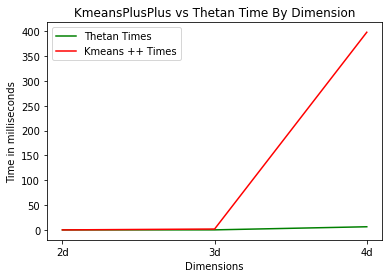

In [7]:
import matplotlib.pyplot as plt

plt.plot(xDimensions, thetanTimes, color= 'green' )
# plt.legend(['Thetan Times'], ['Kmeans ++ Times'])
plt.plot(xDimensions, kmeans_plus_plus_Times, color= 'red')
plt.legend(["Thetan Times", "Kmeans ++ Times"], loc ="upper left")

plt.ylabel('Time in milliseconds')
plt.xlabel('Dimensions')
plt.title("KmeansPlusPlus vs Thetan Time By Dimension")

plt.show()

In [29]:
kmeansnmi = []
kmeanssil = []
kmeansfms = []
thetannmi = []
thetansil = []
thetanfms = []

from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScoreK2D = normalized_mutual_info_score(labels2d, klabels2d)
print(nmiScoreK2D)
silScoreK2D = silhouette_score(points2d, klabels2d)
fmsScoreK2D = fowlkes_mallows_score(labels2d, klabels2d)
nmiScoreT2D = normalized_mutual_info_score(labels2d, tlabels2d)
silScoreT2D = silhouette_score(points2d, tlabels2d)
fmsScoreT2D = fowlkes_mallows_score(labels2d, tlabels2d)
kmeansnmi.append(nmiScoreK2D)
kmeanssil.append(silScoreK2D)
kmeansfms.append(fmsScoreK2D)
thetannmi.append(nmiScoreT2D)
thetansil.append(fmsScoreT2D)
thetanfms.append(fmsScoreT2D)


0.9977795922619891


In [30]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScoreK3D = normalized_mutual_info_score(labels3d, klabels3d)
silScoreK3D = silhouette_score(points3d, klabels3d)
fmsScoreK3D = fowlkes_mallows_score(labels3d, klabels3d)
nmiScoreT3D = normalized_mutual_info_score(labels3d ,tlabels3d)
silScoreT3D = silhouette_score(points3d, tlabels3d)
fmsScoreT3D = fowlkes_mallows_score(labels3d, tlabels3d)
kmeansnmi.append(nmiScoreK3D)
kmeanssil.append(silScoreK3D)
kmeansfms.append(fmsScoreK3D)
thetannmi.append(nmiScoreT3D)
thetansil.append(silScoreT3D)
thetanfms.append(fmsScoreT3D)

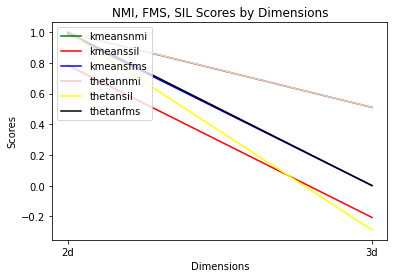

In [21]:
import matplotlib.pyplot as plt
xDimensions2 = ['2d', '3d']
plt.plot(xDimensions2, kmeansnmi, color= 'green' )
plt.plot(xDimensions2, kmeanssil, color= 'red')
plt.plot(xDimensions2, kmeansfms, color= 'blue')
plt.plot(xDimensions2, thetannmi, color= 'pink')
plt.plot(xDimensions2, thetansil, color= 'yellow')
plt.plot(xDimensions2, thetanfms, color= 'black')
# plt.plot(xDimensions2, kmeans_plus_plus_Times, color= 'red')
plt.legend(["kmeansnmi", "kmeanssil","kmeansfms", "thetannmi","thetansil", "thetanfms"], loc ="upper left")

plt.ylabel('Scores')
plt.xlabel('Dimensions')
plt.title("NMI, FMS, SIL Scores by Dimensions")

plt.show()

In [23]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScoreK4D = normalized_mutual_info_score(labels4d, klabels4d)
silScoreK4D = silhouette_score(points4d, klabels4d)
fmsScoreK4D = fowlkes_mallows_score(labels4d, klabels4d)
nmiScoreT4D = normalized_mutual_info_score(labels4d, tlabels4d)
silScoreT4D = silhouette_score(points4d, tlabels4d)
fmsScoreT4D = fowlkes_mallows_score(labels4d, tlabels4d)
kmeansnmi.append(nmiScoreK4D)
kmeanssil.append(silScoreK4D)
kmeansfms.append(fmsScoreK4D)
thetannmi.append(nmiScoreT4D)
thetansil.append(silScoreT4D)
thetanfms.append(fmsScoreT4D)


In [31]:
kmeansnmi.append(nmiScoreK4D)
kmeanssil.append(silScoreK4D)
kmeansfms.append(fmsScoreK4D)
thetannmi.append(nmiScoreT4D)
thetansil.append(silScoreT4D)
thetanfms.append(fmsScoreT4D)

In [32]:
print(kmeansnmi)

[0.9977795922619891, 0.5101584918824632, 0.6306693772544082]


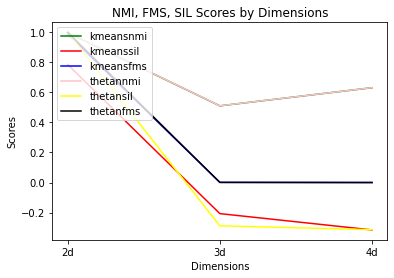

In [33]:
import matplotlib.pyplot as plt
xDimensions2 = ['2d', '3d', '4d']
plt.plot(xDimensions2, kmeansnmi, color= 'green' )
plt.plot(xDimensions2, kmeanssil, color= 'red')
plt.plot(xDimensions2, kmeansfms, color= 'blue')
plt.plot(xDimensions2, thetannmi, color= 'pink')
plt.plot(xDimensions2, thetansil, color= 'yellow')
plt.plot(xDimensions2, thetanfms, color= 'black')
# plt.plot(xDimensions2, kmeans_plus_plus_Times, color= 'red')
plt.legend(["kmeansnmi", "kmeanssil","kmeansfms", "thetannmi","thetansil", "thetanfms"], loc ="upper left")

plt.ylabel('Scores')
plt.xlabel('Dimensions')
plt.title("NMI, FMS, SIL Scores by Dimensions")

plt.show()